In [1]:
# Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Step 2: Load & Sort
df = pd.read_csv('/content/drive/MyDrive/Data Science/TCS_stock_history.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

In [3]:
# Step 3: Cleaning & Preprocessing
# Handle missing and data type issues
df.fillna(method='ffill', inplace=True)
for col in ['Open','High','Low','Close','Volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove remaining NaNs
df.dropna(inplace=True)

/tmp/ipython-input-3-2488675800.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


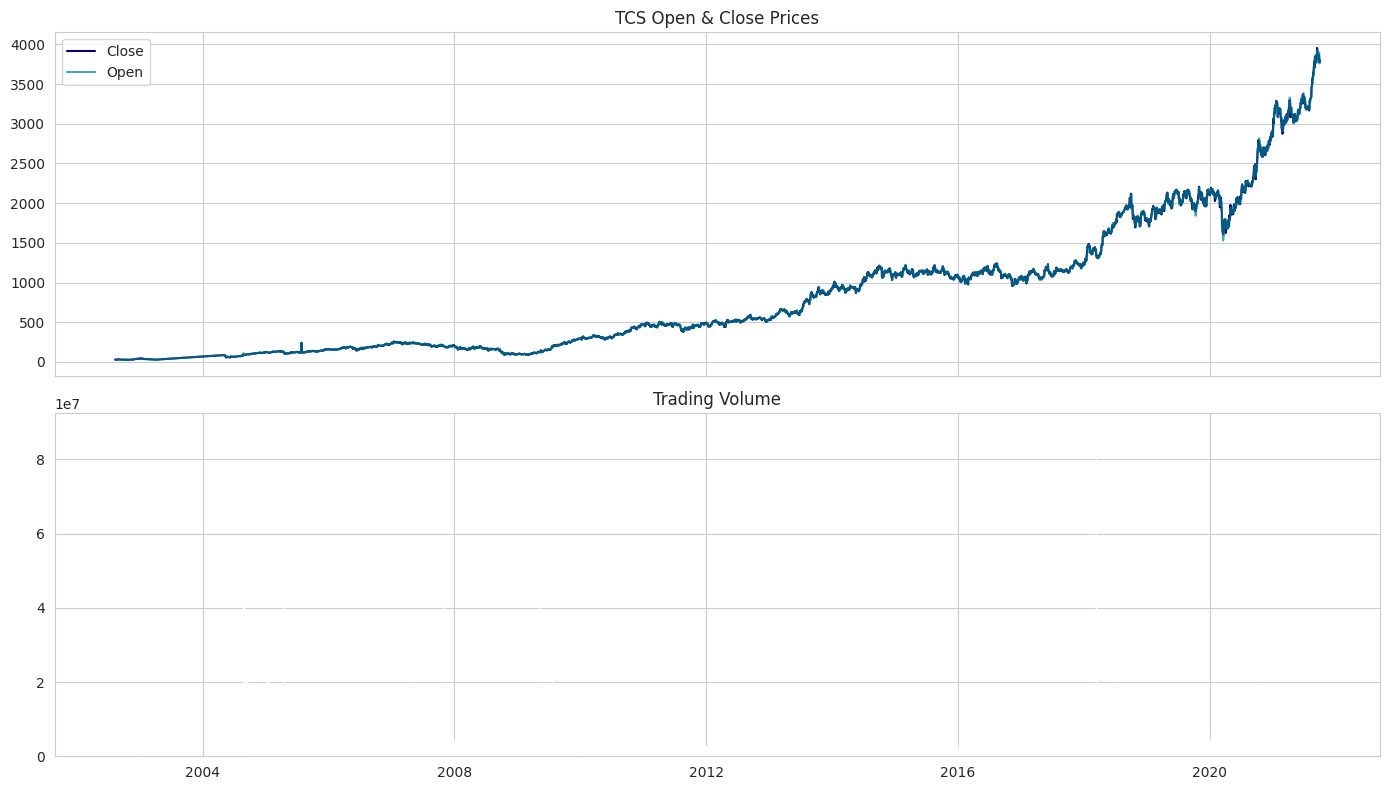

In [4]:
# Step 4: EDA & Visualization
# 4a. Price & Volume Over Time
fig, axs = plt.subplots(2,1, sharex=True, figsize=(14,8))
axs[0].plot(df['Date'], df['Close'], label='Close', color='navy')
axs[0].plot(df['Date'], df['Open'], label='Open', color='teal', alpha=0.7)
axs[0].legend()
axs[0].set_title("TCS Open & Close Prices")
axs[1].bar(df['Date'], df['Volume'], color='orange')
axs[1].set_title("Trading Volume")
plt.tight_layout()
plt.show()

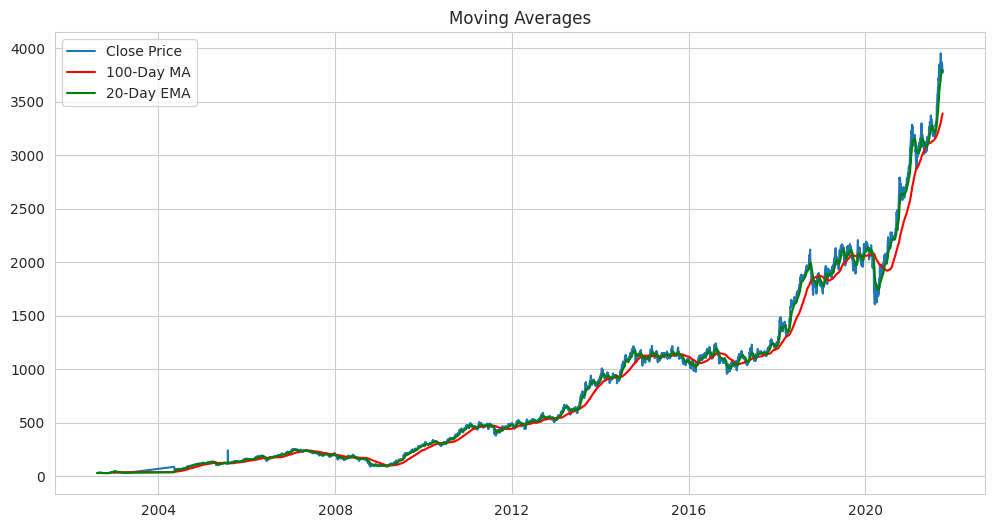

In [5]:
# 4b. Rolling Stats
df['MA100'] = df['Close'].rolling(100).mean()
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['MA100'], label='100‑Day MA', color='red')
plt.plot(df['Date'], df['EMA20'], label='20‑Day EMA', color='green')
plt.legend()
plt.title("Moving Averages")
plt.show()

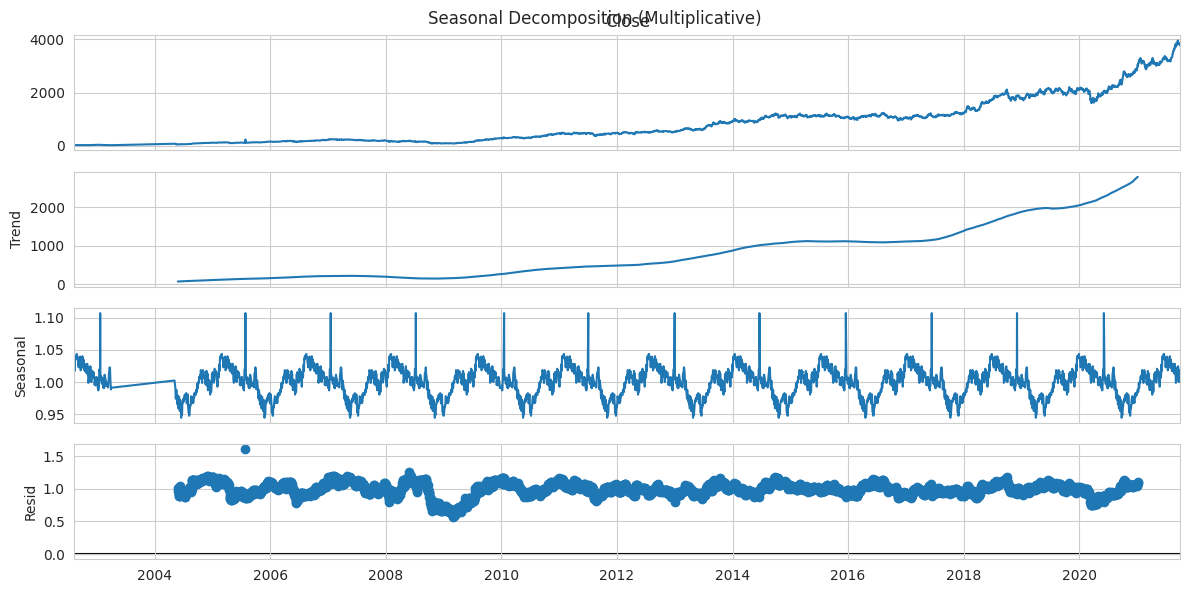

In [6]:
# 4c. Price Trends Decomposition (Seasonal + Trend)
result = seasonal_decompose(df.set_index('Date')['Close'], model='multiplicative', period=365)
result.plot()
plt.suptitle("Seasonal Decomposition (Multiplicative)")
plt.show()

In [7]:
# Step 5: Feature Engineering
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['PrevClose'] = df['Close'].shift(1)
df['DailyReturn'] = df['Close'].pct_change()
df = df.dropna()

In [8]:
# Step 6: Modeling – XGBoost / Gradient Boosting
features = ['Open','High','Low','Volume','PrevClose','DailyReturn','Year','Month','DayOfWeek']
X = df[features]
y = df['Close']
split = int(len(df)*.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

print("GBM MSE:", mean_squared_error(y_test, y_pred))
print("GBM R²:", r2_score(y_test, y_pred))

GBM MSE: 998324.47250989
GBM R²: -1.886436907973363


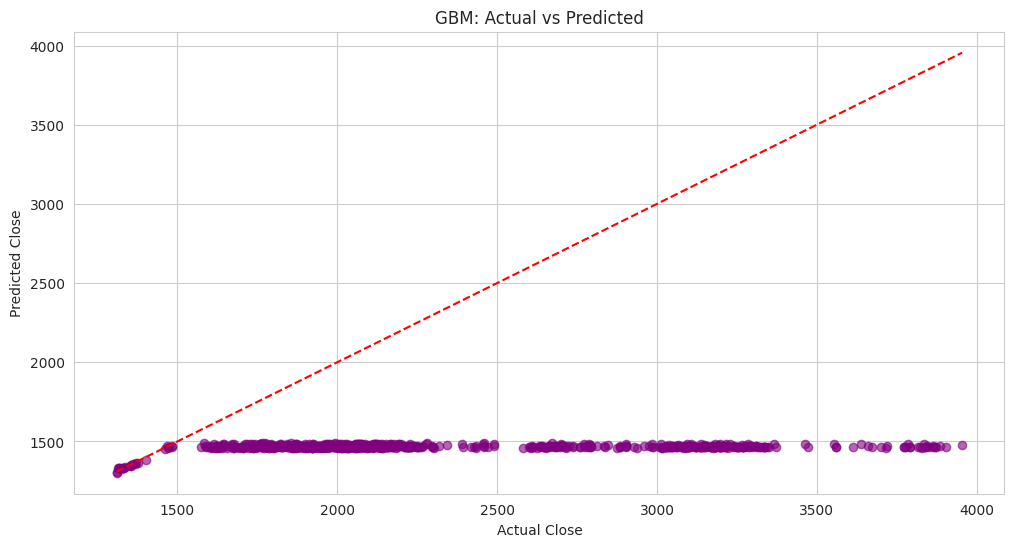

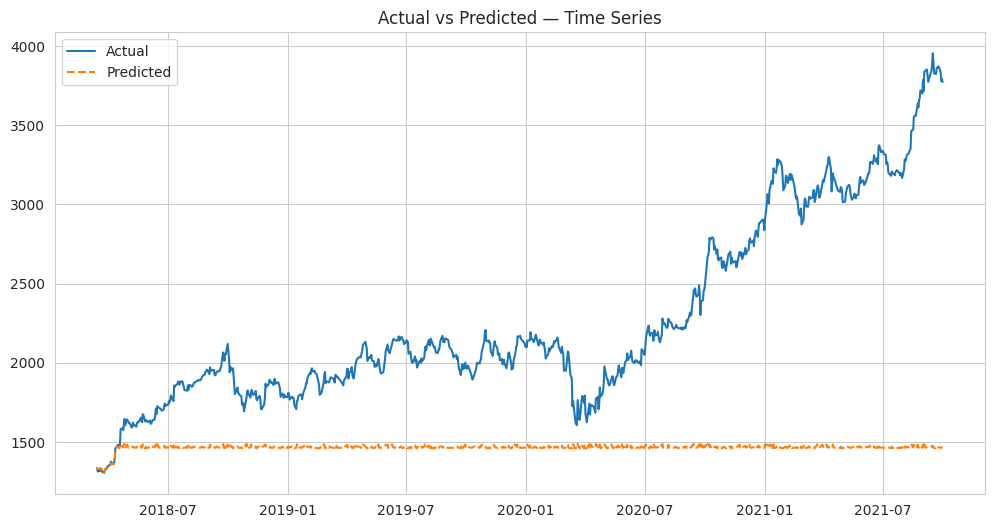

In [9]:
# Step 7: Visualize Predictions
plt.scatter(y_test, y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Close")
plt.ylabel("Predicted Close")
plt.title("GBM: Actual vs Predicted")
plt.show()

plt.plot(df['Date'].iloc[split:], y_test, label='Actual')
plt.plot(df['Date'].iloc[split:], y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.title("Actual vs Predicted — Time Series")
plt.show()

In [11]:
# Step 8: Save Model
with open('tcs_gbm_model.pkl','wb') as f:
    pickle.dump(gb, f)

In [14]:
# ---- Optional: ARIMA Time-Series Forecasting ----
from statsmodels.tsa.arima.model import ARIMA

ts = df.set_index('Date')['Close'].asfreq('B')  # business days
ts = ts.fillna(method='ffill')
split_point = int(len(ts) * 0.8)
train_ts, test_ts = ts[:split_point], ts[split_point:]

/tmp/ipython-input-14-1034415496.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill')


In [15]:
model_arima = ARIMA(train_ts, order=(5,1,2), seasonal_order=(1,1,1,12))
res = model_arima.fit()
print(f"Length of test_ts: {len(test_ts)}")
forecast = res.get_forecast(len(test_ts))
fc_vals = forecast.predicted_mean

Length of test_ts: 979


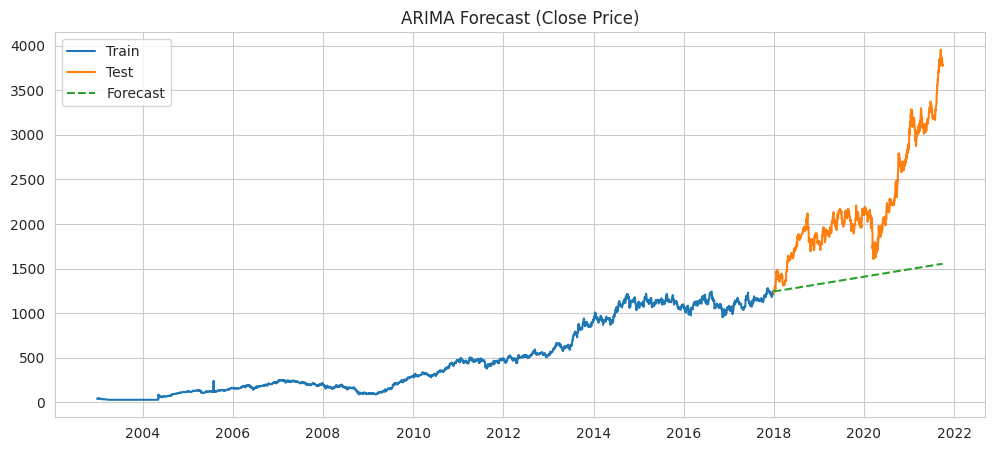

In [16]:
plt.figure(figsize=(12,5))
plt.plot(train_ts.index, train_ts, label='Train')
plt.plot(test_ts.index, test_ts, label='Test')
plt.plot(test_ts.index, fc_vals, label='Forecast', linestyle='--')
plt.legend()
plt.title("ARIMA Forecast (Close Price)")
plt.show()

In [17]:
print("ARIMA MSE:", mean_squared_error(test_ts, fc_vals))
print("ARIMA R²:", r2_score(test_ts, fc_vals))

ARIMA MSE: 960562.1261946968
ARIMA R²: -1.6140035628055864
